<center><h1>Usporedba LSTM arhitekture neuronske mreže ovisno o BERT transformerima na temelju zadatka binarne klasifikacije sentimenta recenzija na hrvatskom jeziku</h1></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Projekt - prva godina/kod/alldatasets_hr

/content/drive/MyDrive/Projekt - prva godina/kod/alldatasets_hr


Packages installation

In [ ]:
# install wrapper for lemmatizer supporting Croatian language, used for preprocessing
!pip install lemmagen3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 23.6 MB/s eta 0:00:00


In [ ]:
# install library transformers - provides thousands of pretrained models
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00


Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import torch
import warnings
warnings.filterwarnings('ignore')

#Uvod

Ovaj projekt prikazuje usporedbu tekstualnih podataka na temelju metoda reprezentacije, koji se nazivaju i ugradnja riječi (eng. word embedding). Usporedba se izvodi na skupu podataka na hrvatskom jeziku koji predstavlja recenzije označene labelama sentimenta. Tri prethodno obučena BERT modeli koriste se za ekstrakciju značajki (eng. feature extraction), a jedan je model obučen na hrvatskom jeziku, a druga dva na engleskom jeziku. Usporedba je napravljena na temelju pristupa algoritama dubokog učenja. Eksperiment mjeri izvedbu modela i daje odgovore na pitanje ovise li metode reprezentacije o jeziku ili je moguće predvidjeti podatke bez obzira na jezik s prihvatljivim manjim pogreškama.

Ciljevi ovog rada mogu su definirani kao:
 - istraživanje važnih koraka predprocesiranja teksta koji utječu na zadatak SA,
 - ispitivanje reprezentacije teksta na temelju performansi SA modela zadataka koristeći već obučene višejezične modele,
 - temeljem mjere klasifikacije, provjeriti izvedbe modela dubokog učenja,
 - provjera postoji li značajna razlika u rezultatima dobivenim klasifikacijom pomoću modela ugradnje riječi obučenih na hrvatskom jeziku u usporedbi s modelima ugradnje riječi obučenih na engleskom jeziku.

# Metodologija

Metodologija uključuje prikupljanje podataka, korake predobrade tekstualnih podataka i tehnike koje se koriste za predstavljanje tekstualnih podataka potrebnih za definiranje i izvršavanje modela. Također, definirani su modeli i algoritmi klasifikacije koji će se koristiti za zadatak SA.

## Dataset

Prikupljanje tekstualnog skupa podataka koji se koristi za ovu studiju izvedeno je korištenjem <a src="https://www.octoparse.com/">Octoparse 8</a>, alata za ekstrakciju koji pomaže korisnicima izdvajanje relevantnih informacija iz različitih vrsta web stranica. Za dohvaćanje podataka potrebno je stvoriti zadatak ekstrakcije koji slijedi pravila po kojima će izvući potrebne podatke. Zadatak se sastoji od slijeda radnji prikazanih na slici ispod. 

Početak zadatka za ekstrakciju je definiranje popisa veza do web stranice <a src="https://www.booking.com/">Booking.com</a>, koji pruža usluge rezervacije na mreži, gdje popis sadrži oko stotinu veza svih vrsta smještaja (hoteli, hosteli, apartmani, kuće za odmor itd.) Splita, Zagreba i Dubrovnika. Sljedeći korak je definiranje petlje gdje se za svaku vezu prikazuju recenzije korisnika, dodatno filtrirane na hrvatskom jeziku. Nakon toga, provodi se ekstrakcija teksta, gdje se odabrani tekstovi pozitivnih i negativnih recenzija izvlače u odvojene stupce. I na kraju, dohvaćanje podataka za svaku vezu na popisu se obrađuje, a rezultirajući podaci se spremaju u excel datoteku.

S obzirom na to da je alat ograničen na obavljanje zadatka na najviše 10 veza, zadatak je izvršen više puta s nekoliko popisa veza. Ukupno je prikupljeno n = 23 excel datoteke koje sadrže recenzije korisnika te su na kraju spojene u jednu excel datoteku s ukupno n = 11 467 zapisa, gdje stupac 'review' prestavlja tekstualne podatke recenzija, a stupac 'label' sadrži jednu od dvije kategorije pozitivno (1) ili negativno (0) ovisno o tekstu recenzija.

<img src="https://drive.google.com/uc?id=13FaruRIpTRItJDoXSiHkiQ8VV1VS-STz" width='30%'/>

In [ ]:
# Read the dataset of Croatian reviews
df = pd.read_excel('HRdataset.xlsx')

In [ ]:
# Dispay first five rows of dataset
df.head()

,review,label
0,Sve je bilo odlično. Gospođa koja nas je doček...,Positive
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",Positive
2,"Odlična lokacija, uredno, srdačna domaćica.",Positive
3,Malen i sladak apartman.,Positive
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,Positive


In [ ]:
# Set 0 and 1 instead of labels "Negative" and "Positive" 

df['label'] = df['label'].replace('Positive', 1)
df['label'] = df['label'].replace('Negative', 0)
df.tail()

,review,label
11462,Steta sto su prozori fiksni.,0
11463,NEMA BESPLATNOG PARKINGA!,0
11464,"Nemam odgovor, sve je EKSTRA!",0
11465,Jako uredno i čisto. Sve je kao i na slikama. ...,1
11466,"Domaćin ljubazan,lokacijama izvrsna udobno i č...",1


In [ ]:
print(f"Veličina skupa podataka je {df.shape}.")

Veličina skupa podataka je (11467, 2).


## Predobrada teksta (text preprocessing)
Podaci dobiveni s društvenih mreža koje sadrže recenzije, komentare ili mišljenja korisnika obično su nestrukturirani, a njihov sirovi oblik može sadržavati mnoge gramatičke i pravopisne pogreške, kao i beskorisne riječi ili znakove.

Stoga je potrebno očistiti i predobraditi tekst u strojno razumljiv format prije analize. Na prikupljenom skupu podataka izvršeni su različiti koraci predobrade, uključujući uklanjanje duplikata i nedefiniranih ili nedostajućih vrijednosti, postavljanje malih slova, uklanjanje zaustavnih riječi i interpunkcijskih znakova, lematizaciju i stemming, te na kraju tokenizaciju.

Prvi korak je uklanjanje dupliciranih zapisa i nedostajućih ili nedefiniranih vrijednosti. Primijećeno je da postoji ukupno n = 2126 dupliciranih entiteta i ukupno n = 2 nedefinirana entiteta, pa je uklanjanjem veličina skupa podataka ili broj ukupnih recenzija smanjen na n = 9339 jedinstvenih zapisa.

In [ ]:
# Remove duplicates

print(f"Postoji ukupno {df.duplicated().sum()} duplih zapisa.")
df = df.drop_duplicates()

Postoji ukupno 2126 duplih zapisa.


In [ ]:
# Remove records with NaN values 
print(f"Postoji ukupno {df.isna().sum().sum()} zapisa sa NaN vrijednostima.")
df = df.dropna()

Postoji ukupno 2 zapisa sa NaN vrijednostima.


In [ ]:
print(f"Finalna veličina skupa podataka je {df.shape}.")

Finalna veličina skupa podataka je (9339, 2).


#### Punctuation Removal

Sljedeći korak predobrade je uklanjanje interpunkcijskih znakova i postavljanje teksta na mala slova. Iz string knjižnice se dohvaća punctuation modul koji sadrži skup svih interpunkcijskih znakova. Izrađuje se metoda koja provjerava svaki znak za svaku recenziju je li u interpunkcijskom skupu. Ako nije interpunkcija, svaki se znak pridružuje i kreira novu recenziju i sprema se u novi stupac nazvan wop_review.

In [ ]:
# library that contains punctuation
import string

# defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree= "".join([i for i in str(text) if i not in string.punctuation])
    return punctuationfree

# storing the no-punctuation text
df['wop_review']= df['review'].apply(lambda x:remove_punctuation(x))
df.head()

,review,label,wop_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...


#### Lowering the text

Za svaki zapis u stupcu wop_review, tekst je postavljen na mala slova i spremljen u novi stupac nazvan l_review.

In [ ]:
# method converts all the case-based characters in a string into lowercased characters
# storing the lowercased text
df['l_review']= df['wop_review'].apply(lambda x: x.lower())
df.head()

,review,label,wop_review,l_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...


#### Stop words removal

Za izvođenje koraka uklanjanja zaustavljenih riječi, korišten je skup zaustavnih riječi na hrvatskom jeziku preuzet i spremljen u txt datoteku s web alata za analizu ključnih riječi Ranks.nl (https://www.ranks.nl/stopwords/croatian). Slično interpunkciji, stvorena je metoda koja provjerava svaku riječ u svakoj recenziji je li na popisu zaustavnih riječi. Ako nije zaustavna riječ, riječi se spoje u novu recenziju i spremaju se u novi stupac nazvan wos_review.

In [ ]:
%cd /content/drive/MyDrive/Projekt - prva godina/kod

/content/drive/MyDrive/Projekt - prva godina/kod


In [ ]:
# file that contains Croatian language stopwords

my_file = open("stopwords_cro.txt", "r")
content = my_file.read()

# storing the stopwords in list
stopwords_list = content.split("\n")
my_file.close()

In [ ]:
# display first 10 stopwords
stopwords_list[0:10]

['a', 'ako', 'ali', 'bi', 'bih', 'bila', 'bili', 'bilo', 'bio', 'bismo']

In [ ]:
# defining the function to remove stopwords from text
def remove_stopwords(text):
  output = " ".join([i for i in text.split(' ') if i not in stopwords_list])
  return output
# storing the no-stopwords text
df['wos_review']= df['l_review'].apply(lambda x:remove_stopwords(x))
df.head()

,review,label,wop_review,l_review,wos_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...


#### Stemming

Stemming i lematizacija su tehnike normalizacije teksta za obradu prirodnog jezika, gdje je stemming proces koji stavlja ili uklanja posljednji karakter riječi, što često dovodi do pogrešnih značenja i pravopisa, dok lematizacija razmatra kontekst i pretvara riječ u bazni oblik, koji se naziva lema. Zadatak koji se pojavljuje izvršen je korištenjem klase StemmerHr za hrvatski jezik preuzet s https://github.com/dmarsic/stemmerhr, dok je modul Lemmagen3, koji podržava hrvatski jezik, korišten za lematizaciju. Za svaki zapis primijenjene su spomenute tehnike, a dobiveni podaci spremni su u nove stupce s_review i lem_review.

In [ ]:
# class that is used for stemming in Croatian language

from StemmerHr.croatian_stemmer.stem import StemmerHr
stemmer = StemmerHr()

# storing the stemmered text
df['s_review']= df['wos_review'].apply(lambda x: stemmer.stem_text(x))
df.head()

,review,label,wop_review,l_review,wos_review,s_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...,"[odličn, gospođ, dočeka, jak, ljubazn, apartma..."
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...,"[lijep, uređen, prozračn, izuzetn, čist, odlič..."
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,"[odličn, lokacij, uredn, srdačn, domaćic]"
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman,"[malen, sladak, apartman]"
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...,"[apartman, izvrsn, lokacij, gospođ, ljubazn, d..."


#### Lematization

In [ ]:
# class that is used for lemmatizing in Croatian language
from lemmagen3 import Lemmatizer
lem_hr = Lemmatizer('hr')

# storing the lemmatized text
df['lem_review']= df['s_review'].apply(lambda x: " ".join([lem_hr.lemmatize(token) for token in x]))
df.head()

,review,label,wop_review,l_review,wos_review,s_review,lem_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...,"[odličn, gospođ, dočeka, jak, ljubazn, apartma...",odličn gospođ dočekati jak ljubazn apartman či...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...,"[lijep, uređen, prozračn, izuzetn, čist, odlič...",lijep urediti prozračn izuzetn čist odličn lok...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,"[odličn, lokacij, uredn, srdačn, domaćic]",odličn lokacij uredn srdačn domaćic
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman,"[malen, sladak, apartman]",malen sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...,"[apartman, izvrsn, lokacij, gospođ, ljubazn, d...",apartman izvrsn lokacij gospođ ljubazn dozvoli...


## Word embedding

Ugradnje riječi (eng. word embeddings) uglavnom se koriste kao ulazne značajke za modele izgrađene za NLP zadatke, uključujući SA. Svaki model zahtijeva ulazni tekst u određenom formatu. Ovaj projekt istražuje kontekstualne (context-based) ugradnje riječi koje obuhvaćaju upotrebe riječi u različitim kontekstima što rezultira preciznijom reprezentacijom značajki. Prednost ovog pristupa u odnosu na druge je u tome što rezultira boljim performansama modela. 

Najviše istraženi modeli koji su implementirani i uspoređeni u su: Bidirectional Encoder Representations (BERT), DistilBERT, RoBERT i ALBERT, modeli obučeni na određenom korpusu s fiksnim rječnikom na engleskom jeziku i CroSloEngual BERT, model obučen na specifičnom korpusu s fiksnim riječnikom na hrvatskom jeziku, koji se dohvaćaju iz biblioteke Transformers (https://github.com/huggingface/transformers), a preuzimanje i dokumentacija modela dostupan je na https://huggingface.co/Modeli.

## Pre-trained BERT modeli

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_class, tokenizer_class, pretrained_weights = (AutoModel, AutoTokenizer, 'EMBEDDIA/crosloengual-bert')

# EMBEDDIA/crosloengual-bert

# Load pretrained model/tokenizer
tokenizer_crosloengual = tokenizer_class.from_pretrained(pretrained_weights)
model_crosloengual = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at EMBEDDIA/crosloengual-bert were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# from transformers import RobertaTokenizer, RobertaModel
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

In [ ]:
# from transformers import AlbertTokenizer, AlbertModel

# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
# model = AlbertModel.from_pretrained("albert-base-v2")

## Tokenization


Svaki model sadrži svoj vlastiti tokenizer koji dijeli recenzije ulaznog teksta, na manje jedinice poznate kao tokeni, a prije učenja modela pretvaraju se u IDs - strukturirana reprezentacija teksta koju računalo može razumijeti i procesirati.

Također, unaprijed obučeni model zahtijevaju da sav ulazni tekst bude identične duljine, tako da je definiran parametar maksimalne duljine. U ovom se slučaju duljina definira ovisno o broju tokena svake recenzije. Odabrana vrijednost je max_length = 64. Ako recenzija sadrži duljinu manju od maksimalne duljine, dodaje se padding (prazni tokeni), ali ako je duži tada se tokeni skraćuju.

In [ ]:
# Tokenization using CroSloEngual BERT tokenizer

tokenized_crosloengual = df.lem_review.apply((
    lambda x: tokenizer_crosloengual.encode_plus(
        x,
        truncation = True,
        max_length = 64,
        pad_to_max_length = True,
        add_special_tokens = True,
        return_attention_mask = True)))

In [ ]:
tokenized_crosloengual[0]

{'input_ids': [103, 22078, 36779, 20339, 38302, 35842, 1007, 12534, 13493, 13957, 34328, 27186, 10723, 1045, 12768, 4326, 13175, 1045, 6526, 11156, 24811, 39219, 1055, 18055, 13493, 13957, 4187, 1250, 2529, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
torch.tensor(tokenized_crosloengual[0]['input_ids'])

tensor([  103, 22078, 36779, 20339, 38302, 35842,  1007, 12534, 13493, 13957,
        34328, 27186, 10723,  1045, 12768,  4326, 13175,  1045,  6526, 11156,
        24811, 39219,  1055, 18055, 13493, 13957,  4187,  1250,  2529,   104,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [ ]:
torch.tensor(tokenized_crosloengual[0]['attention_mask'])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Tokenization using BERT tokenizer

tokenized_bert = df.lem_review.apply((
    lambda x: tokenizer_bert.encode_plus(
        x,
        truncation = True,
        max_length = 64,
        pad_to_max_length = True,
        add_special_tokens = True,
        return_attention_mask = True)))

In [ ]:
# Tokenization using DistilBERT tokenizer

tokenized_distilbert = df.lem_review.apply((
    lambda x: tokenizer_distilbert.encode_plus(
        x,
        truncation = True,
        max_length = 64,
        pad_to_max_length = True,
        add_special_tokens = True,
        return_attention_mask = True)))

## Last hidden states

U kontekstu obučenog jezičnog modela poput BERTa, `last hidden state` odnosi se na konačni sloj skrivenih stanja generiranog modelom prilikom obrade ulaznog slijeda.

Ovaj konačni sloj sadrži prikaz ulaznog niza koji je transformiran pomoću težina modela i koristi se za klasifikaciju teksta.

Značajke u posljednjem skrivenom stanju su nsučene modelom tijekom predobuke na velikom količinom tekstualnih podataka. Model je obučen za predviđanje sljedeće riječi u rečenici s obzirom na prethodne riječi u rečenici. Kao rezultat, `last hidden state` je reprezentacija ulaznog slijeda koji bilježi semantičke i kontekstualne informacije, poput značenja riječi, odnosa između riječi i sintakse.

In [ ]:
# Get last hidden states for CroSloEngual BERT model
last_hidden_states_crosloengual = []
# count  = 0
for tokens in tokenized_crosloengual:
    # # Convert tokens to PyTorch tensor
    tokens_tensor = torch.tensor(tokens['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0)
    # count = count + 1
    # print(count)

    # Get last hidden states from model
    with torch.no_grad():
        outputs = model_crosloengual(tokens_tensor, attention_mask = attention_mask)
        last_hidden_state = outputs.last_hidden_state
        
    last_hidden_states_crosloengual.append(last_hidden_state)

In [ ]:
last_hidden_states_crosloengual[0].shape

torch.Size([1, 64, 768])

In [ ]:
# Get last hidden states for BERT model
last_hidden_states_bert = []
# count = 0

for tokens in tokenized_bert:
    # # Convert tokens to PyTorch tensor
    tokens_tensor = torch.tensor(tokens['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0)
    # count = count + 1
    # print(count)
    # Get last hidden states from model
    with torch.no_grad():
        outputs = model_bert(tokens_tensor, attention_mask = attention_mask)
        last_hidden_state = outputs.last_hidden_state
        
    last_hidden_states_bert.append(last_hidden_state)

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526


In [ ]:
# Get last hidden states for DistilBERT
last_hidden_states_distilbert = []
count = 0

for tokens in tokenized_distilbert:
    # # Convert tokens to PyTorch tensor
    #tokens_tensor = torch.tensor(tokens).unsqueeze(0)
    tokens_tensor = torch.tensor(tokens['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0)
    count = count + 1
    print(count)
    # Get last hidden states from model
    with torch.no_grad():
        outputs = model_distilbert(tokens_tensor, attention_mask = attention_mask)
        last_hidden_state = outputs.last_hidden_state
        
    last_hidden_states_distilbert.append(last_hidden_state)

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526


In [ ]:
last_hidden_states_bert[0].shape

torch.Size([1, 64, 768])

In [ ]:
last_hidden_states_distilbert[0].shape

torch.Size([1, 64, 768])

# Rezultati

## Model #1: LSTM neural network

Uzima se samo dio izlaza koji je potreban, a to je izlaz koji odgovara prvom tokenu svake rečenice. Način na koji BERT radi klasifikaciju rečenica jest taj što dodaje token nazvan `[CLS]` (za klasifikaciju) na početku svake rečenice. Izlaz koji odgovara tom tokenu može se smatrati word embedding za cijelu rečenicu.

Spremit će se u varijablu `features`, jer će oni poslužiti kao značajke modela klasifikacije.

In [ ]:
# Extract the first last hidden state vector for each review for each model

# features_crosloengual = np.array([lh[0][0].numpy() for lh in last_hidden_states_crosloengual])
# features_bert = np.array([lh[0][0].numpy() for lh in last_hidden_states_bert])
# features_distilbert = np.array([lh[0][0].numpy() for lh in last_hidden_states_distilbert])

In [ ]:
# Save features to files

# np.save('features_crosloengual.npy', features_crosloengual)
# np.save('features_bert.npy', features_bert)
# np.save('features_distilbert.npy', features_distilbert)

In [ ]:
# Load features from files

features_crosloengual = np.load('features_crosloengual.npy')
features_bert = np.load('features_bert.npy')
features_distilbert = np.load('features_distilbert.npy')

In [ ]:
features_crosloengual.shape, features_bert.shape, features_distilbert.shape

((9339, 768), (9339, 768), (9339, 768))

Skup podataka podijeljen je na skup za treniranje (80%) i skup za testiranje podataka (20%).


Vrši se i reshape podataka jer ulazni oblik sloja LSTM zahtijeva 3D ulazni tenzor.

U ovom slučaju, ulazni tenzor ima oblik (batch_size, 768), gdje je 768 broj značajki za svaki uzorak. Da bi se to pretvorili u potreban 3D oblik, potrebno je preoblikovati ulazni tenzor u oblik (batch_size, 1, 768), gdje je nova dimenzija predstavljena kao jedan vremenski korak u svakom uzorku.

In [ ]:
# Split data into training and testing sets

X_train_cse, X_test_cse, y_train_cse, y_test_cse = train_test_split(features_crosloengual, labels, test_size=0.2, random_state=42)
X_train_cse_reshaped = X_train_cse.reshape(-1, 1, 768)
X_test_cse_reshaped = X_test_cse.reshape(-1, 1, 768)

In [ ]:
X_train_cse.shape

(7471, 768)

Postoji neravnoteža klasa, pa se mogu razmotriti upotreba tehnika kao što su oversampling ili undersampling za uravnoteženje klasa. Oversampling uključuje dodavanje kopija uzoraka manjinske klase u skup podataka, dok undersampling uključuje uklanjanje nekih uzoraka iz većinske klase kako bi se uravnotežila klasa. U ovom slučaju koristit će se tehnika oversampling.

In [ ]:
# Convert labels to numpy array
labels = np.array(df['label'])

In [ ]:
counts = df['label'].value_counts()
print(counts)

1    5909
0    3430
Name: label, dtype: int64


In [ ]:
# Apply random oversampling to the minority class
ros = RandomOverSampler(random_state=42)
X_cse_resampled, y_cse_resampled = ros.fit_resample(X_train_cse, y_train_cse)
X_cse_reshaped = X_cse_resampled.reshape(-1, 1, 768)

In [ ]:
X_cse_resampled.shape, y_cse_resampled.shape

((9460, 768), (9460,))

In [ ]:
X_cse_reshaped.shape

(9460, 1, 768)

#### Model LSTM i CroSloEngual BERT značajke

In [ ]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(1, 768)))
model_lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train model
history_cse = model_lstm.fit(X_cse_reshaped, y_cse_resampled, epochs=10, batch_size=32, validation_data=(X_test_cse_reshaped, y_test_cse))

Epoch 1/10
296/296 [==============================] - 11s 9ms/step - loss: 0.3780 - accuracy: 0.8352 - val_loss: 0.3324 - val_accuracy: 0.8571
Epoch 2/10
296/296 [==============================] - 2s 5ms/step - loss: 0.3100 - accuracy: 0.8681 - val_loss: 0.3180 - val_accuracy: 0.8683
Epoch 3/10
296/296 [==============================] - 1s 5ms/step - loss: 0.2777 - accuracy: 0.8847 - val_loss: 0.3122 - val_accuracy: 0.8763
Epoch 4/10
296/296 [==============================] - 1s 5ms/step - loss: 0.2644 - accuracy: 0.8862 - val_loss: 0.3543 - val_accuracy: 0.8453
Epoch 5/10
296/296 [==============================] - 2s 5ms/step - loss: 0.2451 - accuracy: 0.8994 - val_loss: 0.3632 - val_accuracy: 0.8399
Epoch 6/10
296/296 [==============================] - 2s 5ms/step - loss: 0.2310 - accuracy: 0.9049 - val_loss: 0.3114 - val_accuracy: 0.8630
Epoch 7/10
296/296 [==============================] - 1s 5ms/step - loss: 0.2131 - accuracy: 0.9078 - val_loss: 0.3272 - val_accuracy: 0.8672
Epoch

Koristi se točnost kao metrika za ocjenjivanje performanse modela jer se rješava problem binarne klasifikacije gdje se želi predvidjeti je li recenzija pozitivna ili negativna.

Točnost je uobičajena metrika za probleme binarne klasifikacije i mjeri udio ispravnih predviđanja koje je model napravio od svih predviđanja. Izračunava se kao broj istinitih pozitivnih i istinitih negativnih podijeljen s ukupnim brojem uzoraka.

Vrijednost gubitka predstavlja vrijednost funkcije gubitka binarne unakrsne entropije na skupu podataka za testiranje. Binarna unakrsna entropija uobičajena je funkcija gubitka koja se koristi u problemima binarne klasifikacije. On mjeri razliku između predviđene raspodjele vjerojatnosti modela i stvarne raspodjele vjerojatnosti podataka.

In [ ]:
# Print test accuracy
test_loss, test_acc = model_lstm.evaluate(X_test_cse_reshaped, y_test_cse)
print('LSTM test accuracy using CroSloEngual BERT: {:.2f} %'.format(test_acc*100))

59/59 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.8571
LSTM test accuracy using CroSloEngual BERT: 85.71 %


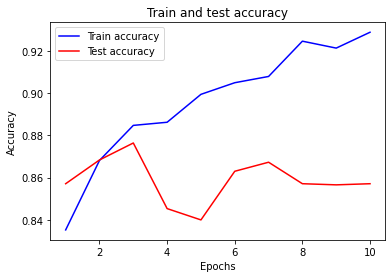

In [ ]:
# Plot training and test accuracy
train_acc = history_cse.history['accuracy']
test_acc = history_cse.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Train accuracy')
plt.plot(epochs, test_acc, 'b', color = 'red', label='Test accuracy')
plt.title('Train and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Vrijednosti točnosti treninga pokazuju koliko se model izvodi na podacima o treningu. U slučaju korištenja CroSloEngual BERT modela, točnost treninga povećava se s 83,52% u prvoj epohi na 92,88% u posljednjoj epohi. To ukazuje na to da model uči kako bi preciznije predviđao podatke o treningu kako trening napreduje.

Vrijednosti točnosti testiranja pokazuju koliko je model generalizirao na nove, neviđene podatke. Točnost testiranja varira između 83,99% i 87,63% u 10. epohi. To ukazuje da se model ne uklapa u podatke za treniranje, jer je točnost testa relativno stabilna i ne pokazuje značajno smanjenje. Međutim, točnost testiranja je nešto niža od točnosti treniranja, što se u većini slučajeva očekuje.


59/59 [==============================] - 1s 3ms/step


<AxesSubplot:>

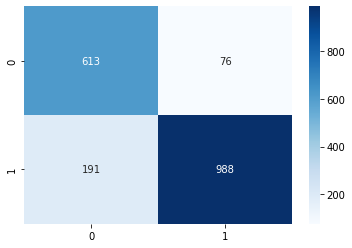

In [ ]:
# Make predictions on test set
y_pred = model_lstm.predict(X_test_cse_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_cse, y_pred)

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

Iz matrice konfuzije možemo vidjeti da je model predvidio 612 istinitih negativnih (TN), 76 lažnih pozitivnih (FP), 191 lažnih negativnih (FN) i 988 istinitih pozitivnih (TP) recenzija.

- Istiniti pozitivni (TP): Model je ispravno predvidio da 988 uzoraka pripada pozitivnoj klasi.
- Istiniti negativi (TN): Model je ispravno predvidio da 613 uzoraka pripada negativnoj klasi.
- Lažni pozitivni (FP): Model je pogrešno predvidio da 76 uzoraka pripada pozitivnoj klasi.
- Lažni negativi (FN): Model je pogrešno predvidio da 191 uzoraka pripada negativnoj klasi.

Dakle, model bolje predviđa negativnu klasu (0) jer ima manje lažno negativnih (76) u usporedbi s pozitivnom klasom (1) koja ima više lažno pozitivnih rezultata (191).

#### Definicija modela LSTM i BERT značajke

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(features_bert, labels, test_size=0.2, random_state=42)
X_train_bert_reshaped = X_train_bert.reshape(-1, 1, 768)
X_test_bert_reshaped = X_test_bert.reshape(-1, 1, 768)

In [ ]:
# Train model
history_bert = model_lstm.fit(X_train_bert_reshaped, y_train_bert, epochs=10, batch_size=32, validation_data=(X_test_bert_reshaped, y_test_bert))

Epoch 1/10
234/234 [==============================] - 1s 6ms/step - loss: 0.5052 - accuracy: 0.7395 - val_loss: 0.4804 - val_accuracy: 0.7543
Epoch 2/10
234/234 [==============================] - 1s 5ms/step - loss: 0.4311 - accuracy: 0.7992 - val_loss: 0.4418 - val_accuracy: 0.7810
Epoch 3/10
234/234 [==============================] - 1s 5ms/step - loss: 0.4121 - accuracy: 0.8114 - val_loss: 0.4228 - val_accuracy: 0.7896
Epoch 4/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3982 - accuracy: 0.8160 - val_loss: 0.4060 - val_accuracy: 0.8035
Epoch 5/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3830 - accuracy: 0.8251 - val_loss: 0.4251 - val_accuracy: 0.7950
Epoch 6/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3705 - accuracy: 0.8355 - val_loss: 0.4039 - val_accuracy: 0.8137
Epoch 7/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3667 - accuracy: 0.8368 - val_loss: 0.3897 - val_accuracy: 0.8212
Epoch 

In [ ]:
# Print test accuracy
test_loss, test_acc = model_lstm.evaluate(X_test_bert_reshaped, y_test_bert)
print('LSTM test accuracy using BERT: {:.2f} %'.format(test_acc*100))

59/59 [==============================] - 0s 3ms/step - loss: 0.3832 - accuracy: 0.8287
LSTM test accuracy using BERT: 82.87 %


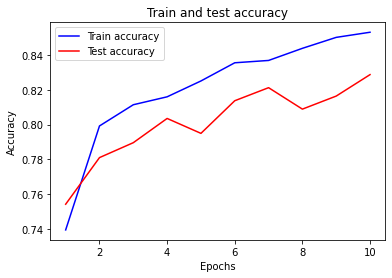

In [ ]:
# Plot training and test accuracy
train_acc = history_bert.history['accuracy']
test_acc = history_bert.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Train accuracy')
plt.plot(epochs, test_acc, 'b', color = 'red', label='Test accuracy')
plt.title('Train and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Točnost treniranja počinje od oko 73,95% i povećava se na 85,30% nakon 10 epoha. To znači da je model u stanju klasificirati podatke o treningu s točnošću od oko 85%.

Točnost testiranja počinje od oko 75,43% i povećava se na 82,87% nakon 10 epoha. To znači da je model u stanju klasificirati testne podatke s točnošću od oko 82%, što nije previše daleko od točnosti treninga.

Međutim, vrijedno je napomenuti da je razlika između točnosti treniranja i testiranja relativno mala, što sugerira da model nije pretjerano overfitan na podatke za treniranje.

59/59 [==============================] - 0s 2ms/step


<AxesSubplot:>

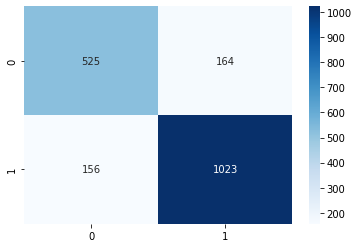

In [ ]:
# Make predictions on test set
y_pred = model_lstm.predict(X_test_bert_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_bert, y_pred)

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

Iz matrice konfuzije možemo vidjeti da je model predvidio 525 istinitih negativnih (TN), 164 lažnih pozitivnih (FP), 156 lažnih negativnih (FN) i 1023 istinitih pozitivnih (TP) recenzija.

- Istiniti pozitivni (TP): Model je ispravno predvidio da 1023 uzoraka pripada pozitivnoj klasi.
- Istiniti negativi (TN): Model je ispravno predvidio da 525 uzoraka pripada negativnoj klasi.
- Lažni pozitivni (FP): Model je pogrešno predvidio da 164 uzoraka pripada pozitivnoj klasi.
- Lažni negativi (FN): Model je pogrešno predvidio da 156 uzoraka pripada negativnoj klasi.

Dakle, model je bolji u predviđanju klase 1 (pozitivna klasa) jer je točno predvidio 1023 instance (prave pozitivne) od ukupno 1179 stvarnih pozitivnih instanci (prave pozitivne + lažno negativne). Nasuprot tome, model je točno predvidio samo 525 od ukupno 689 stvarnih negativnih instanci (pravi negativni + lažno pozitivni).

#### Definicija modela LSTM i DistilBERT značajke

In [ ]:
X_train_distilbert, X_test_distilbert, y_train_distilbert, y_test_distilbert = train_test_split(features_distilbert, labels, test_size=0.2, random_state=42)
X_train_distilbert_reshaped = X_train_distilbert.reshape(-1, 1, 768)
X_test_distilbert_reshaped = X_test_distilbert.reshape(-1, 1, 768)

In [ ]:
# Train model
history_distilbert = model_lstm.fit(X_train_distilbert_reshaped, y_train_distilbert, epochs=10, batch_size=32, validation_data=(X_test_distilbert_reshaped, y_test_distilbert))

Epoch 1/10
234/234 [==============================] - 2s 9ms/step - loss: 0.4456 - accuracy: 0.7901 - val_loss: 0.4429 - val_accuracy: 0.7923
Epoch 2/10
234/234 [==============================] - 2s 10ms/step - loss: 0.4079 - accuracy: 0.8137 - val_loss: 0.4242 - val_accuracy: 0.8067
Epoch 3/10
234/234 [==============================] - 2s 10ms/step - loss: 0.3891 - accuracy: 0.8220 - val_loss: 0.3995 - val_accuracy: 0.8191
Epoch 4/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3781 - accuracy: 0.8303 - val_loss: 0.3887 - val_accuracy: 0.8201
Epoch 5/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3668 - accuracy: 0.8379 - val_loss: 0.3865 - val_accuracy: 0.8319
Epoch 6/10
234/234 [==============================] - 1s 5ms/step - loss: 0.3586 - accuracy: 0.8419 - val_loss: 0.3804 - val_accuracy: 0.8271
Epoch 7/10
234/234 [==============================] - 1s 6ms/step - loss: 0.3537 - accuracy: 0.8474 - val_loss: 0.4062 - val_accuracy: 0.8110
Epoc

In [ ]:
# Print test accuracy
test_loss, test_acc = model_lstm.evaluate(X_test_distilbert_reshaped, y_test_distilbert)
print('LSTM test accuracy using DistilBERT: {:.2f} %'.format(test_acc*100))

59/59 [==============================] - 0s 4ms/step - loss: 0.3661 - accuracy: 0.8405
LSTM test accuracy using DistilBERT: 84.05 %


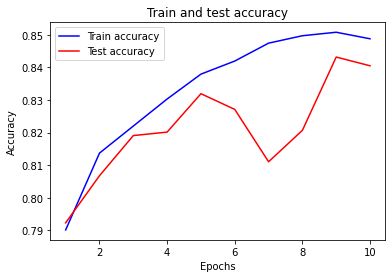

In [ ]:
# Plot training and test accuracy
train_acc = history_distilbert.history['accuracy']
test_acc = history_distilbert.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Train accuracy')
plt.plot(epochs, test_acc, 'b', color = 'red', label='Test accuracy')
plt.title('Train and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Može se vidjeti da je točnost treniranja počinje od 79,01% i postupno se poboljšava, dosegnuvši maksimalno 85,07% u devetoj epohi prije nego što je u posljednjoj epohi malo pala na 84,87%.

S druge strane, točnost testiranja počinje od 79,23% i pokazuje sličan obrazac poboljšanja, dosegnuvši maksimalno 84,31% u devetoj epohi prije nego što je u posljednjoj epohi malo pala na 84,05%.

Sve u svemu, možemo vidjeti da je model naučio razumno dobro raditi na podacima treniranja i testiranja, a obje se točnosti dosljedno poboljšavaju tijekom epoha treninga. Međutim, vrijedno je napomenuti da je točnost testiranja nešto niža od točnosti treniranja, što sugerira da model može malo pretjerati s podacima treniranja.

59/59 [==============================] - 0s 2ms/step


<AxesSubplot:>

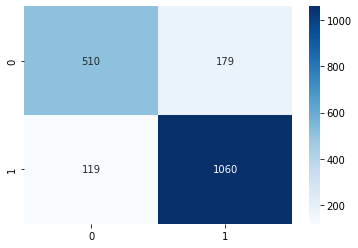

In [ ]:
# Make predictions on test set
y_pred = model_lstm.predict(X_test_distilbert_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_distilbert, y_pred)

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

Iz matrice konfuzije možemo vidjeti da je model predvidio 510 istinitih negativnih (TN), 179 lažnih pozitivnih (FP), 119 lažnih negativnih (FN) i 1060 istinitih pozitivnih (TP) recenzija.

- Istiniti pozitivni (TP): Model je ispravno predvidio da 1060 uzoraka pripada pozitivnoj klasi.
- Istiniti negativi (TN): Model je ispravno predvidio da 510 uzoraka pripada negativnoj klasi.
- Lažni pozitivni (FP): Model je pogrešno predvidio da 179 uzoraka pripada pozitivnoj klasi.
- Lažni negativi (FN): Model je pogrešno predvidio da 119 uzoraka pripada negativnoj klasi.

Dakle, može se vidjeti da model bolje predviđa pozitivnu klasu (1) jer ima više istinitih pozitivnih rezultata (1060) i manje lažno negativnih (119) u usporedbi s negativnom klasom (0) koja ima više lažno pozitivnih rezultata ( 179) i manje istinitih negativnih (510).

# Zaključak

Ovaj projekt opisuje postupak zadatka analize osjećaja korištenjem različitih tehnika word embeddingsa i algoritama klasifikacije, uz važne koraka za predobradu prikupljenih tekstualnih podataka. Podaci su prikupljeni na temelju recenzija različitih korisnika stranice Booking.com, a sadrže ukupno 11.467 zapisa na hrvatskom jeziku označenih polaritetima negativan (0) ili pozitivan (1). Nakon obrade prikupljenih podataka definiraju se modeli ugradnje riječi i izrađuju se predviđanja pomoću algoritma LSTM neuronske mreže. Rezultati istraživanja pokazali su da vrlo važnu ulogu u predviđanju imaju modeli koji su već obučeni za jezik na kojem se analiza izvodi.

Tako je ovaj eksperiment pokazao visoku točnost od 85,7% u slučaju kada je korišten CroSloEngual BERT model, prethodno treniran na korpusu hrvatskog jezika. Također, važno je spomenuti da su ostali modeli prethodno obučeni na engleskom dali vrlo dobre rezultate, a razlika je u oko 8%. Stoga su se vrlo dobrim pokazali i druga dva modela BERT i DistilBERT, gdje je točnost prvog oko 82,8\%, a drugog 84\%.

Nadalje, važno je istaknuti da ne postoji dovoljan broj javno dostupnih označenih skupova podataka na hrvatskom jeziku koji se koriste za zadatak SA, pa se ističe i doprinos prikupljanjem novog skupa podataka koji se može koristiti za daljnja istraživanja u polju NLP-a. Također, ističe se korisni alat Octoparse koji se može koristiti za online dohvaćanje podataka s raznih web stranica.

Dan je naglasak i na važne korake pretprocesiranja koji mogu utjecati na izvedbu predviđanja, stoga je vrlo važno izvršiti gore navedene operacije prije SA zadatka kako bi se postigla bolja izvedba modela i smanjila dimenzionalnost ulaznih podataka, što smanjuje vrijeme i memoriju izvršavanja modela, što je bilo vrlo vidljivo tijekom eksperimenta.

U budućem radu bit će uključeni i analizirani i drugi jezici, a najzanimljiviji rezultati mogli bi se postići usporedbom jezika sličnih hrvatskom, poput srpskog ili bosanskog. Pokušat će se uključiti još nekoliko koraka čišćenja i predobrade podataka, kao što su značajke izdvajanja oznaka dijela govora (PoS), negacija, te proširiti domenu istraživanja i usporediti sa različitim algoritmima klasifikacije.